# Library imports

In [1]:
import numpy as np
import math as math
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import matplotlib.pyplot as plt
from pylab import *
import scipy.linalg
import seaborn as sns
import time
import glob
import pandas as pd

import itertools

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.metrics import mean_squared_error, mean_absolute_error
 
from scipy.optimize import curve_fit

from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets

# Utils

In [2]:
def get_location(arr, loc):
  return np.where((arr[:,0] == loc[0])&(arr[:,1] == loc[1]))[0][0]

In [3]:
def split_df(row):
  '''
  Special distances correction
  '''
  aux = df.loc[(df['x'] == row[0]) & (df['y'] == row[1])]
  aux = aux[ap_mac].values
  aux = aux.T

  return aux

In [4]:
def mean_confidence_interval(data, confidence=0.95):
    """
    Clear nan values
    """
    idx = np.argwhere(np.isnan(data)).T[0]
    data = np.delete(data, idx, 0)

    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.nanmean(a), scipy.stats.sem(a, nan_policy='omit')

    """
    Check nan
    """
    if n > 1:
      h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    else:
      h = 0
      
    return m.round(2), (m-h).round(2), (m+h).round(2)

In [5]:
def vec_mean(vec, fac):
  """
  Vector length
  """
  l = int(floor(len(vec)/fac))

  """
  Vector reshaping
  """
  vec = vec[:l*fac].reshape(l,fac)

  """
  Mean computing
  """
  return np.nanmean(vec, axis=1)

In [6]:
def compute_euclidean_distance(array):
    n = array.shape[0]

    d_mat = [np.linalg.norm(i - j) for (i,j) in itertools.product(array, array)]
    d_mat = np.array(d_mat).reshape((n, n), order='F')

    return d_mat

In [7]:
def fits_interval(estimation, measure):
  """
  Check whether estimated value is inside the expected measure
  """
  if(not((estimation[2] < measure[1]) | (measure[2] < estimation[1]))):
    return 1
  else:
    return 0

In [8]:
def mean_squared_error(arr, ax=0):
  return np.sqrt(np.square(arr).mean(ax)).round(2)

In [9]:
def get_window_mean(obs, n):
  """
  Length of the observation vector
  """
  l = len(obs)

  """
  Circular saving
  """
  aux = np.insert(obs, 0, obs)

  return pd.DataFrame(aux)[0].rolling(n, min_periods=1).mean()[l:]

# Dataset Reading

In [10]:
"""
File reading
"""
df = pd.read_csv('../data/dataset_sala_actos_pixel.csv', sep = ",", index_col=False, encoding='latin-1')
df = df.replace(to_replace = -100, value = np.nan)
df.head()

,batch,x,y,z,brand,model,angle,sampleNumber,30:23:03:87:17:80#1,30:23:03:87:17:81#1,...,30:23:03:87:19:6c#1,30:23:03:87:19:6d#1,30:23:03:87:19:6e#1,36:23:03:87:17:80#1,36:23:03:87:17:98#1,36:23:03:87:19:6c#1,58:cb:52:d7:b4:d9#1,58:cb:52:d7:b5:31#1,58:cb:52:d7:b5:5d#1,58:cb:52:d7:bb:61#1
0,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,0,20.932,7.352,...,25.707,9.154,8.529,NaN,33.241,NaN,17.664,4.720,-0.504,16.417
1,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,1,19.757,7.469,...,25.620,8.669,8.602,NaN,NaN,NaN,17.976,4.183,-0.348,16.614
2,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,2,18.669,7.041,...,25.232,8.913,8.734,NaN,NaN,NaN,18.248,3.533,-0.110,16.854
3,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,3,19.770,6.913,...,NaN,9.026,8.705,NaN,NaN,NaN,17.664,3.421,-0.123,16.651
4,00ecbbfc674d9acb63628124675dca47,2.0,0.0,0.0,google,Pixel 3a,0.0,4,20.232,7.273,...,26.088,8.829,8.646,NaN,NaN,NaN,18.086,3.390,-0.191,16.692


# Radio-map definition

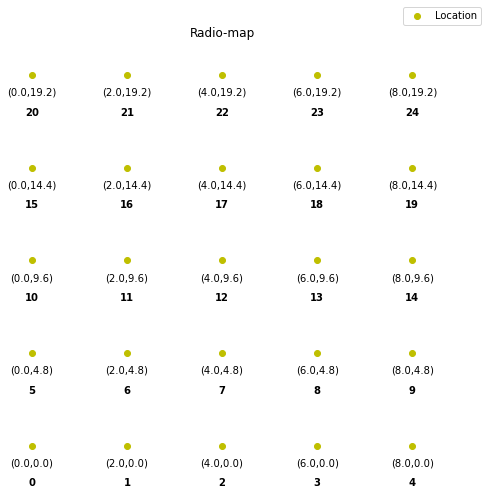

In [12]:
width =  8
height = 19.2

granularity_x = 2
granularity_y = 4.8

points_x = int(width/float(granularity_x) +1)
points_y = int(height/float(granularity_y) +1)

n_points = points_x * points_y

"""
Locations grid
"""
locations = np.array(np.meshgrid(np.linspace(0, height, points_y).round(2), np.linspace(0, width, points_x).round(2))).T.reshape(-1,2)
locations[:, [1, 0]] = locations[:, [0, 1]]

"""
Plot coordinates
"""
coordinates = np.array(np.meshgrid(np.linspace(0, points_y - 1, points_y), np.linspace(0, points_x - 1, points_x))).T.reshape(-1,2)
coordinates[:, [1, 0]] = coordinates[:, [0, 1]]

plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates[:,0], coordinates[:,1], c='y')

plt.legend(labels=['Location'],loc="upper right",borderaxespad=-5)
plt.title('Radio-map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

# AP definition

## AP class

### Handles the required parameters for each AP

#### Parameters:

*   name (string)
*   x (number)
*   y (number)
*   point (number)
*   mac (string)

In [13]:
class AP:
    '''
 
    '''
    def __init__(self, _name, _x, _y, _mac):
        self.name = _name
        self.x = _x
        self.y = _y
        self.mac = _mac
        self.point = get_location(locations, [_x, _y])

## Create APs

In [14]:
"""
Selected APs for the experiment
"""

ap_list = []

ap_list.append(AP('Google White', 0, 19.2, '58:cb:52:d7:bb:61#1'))

ap_list.append(AP('Google Blue', 0, 0, '58:cb:52:d7:b5:5d#1'))

ap_list.append(AP('Google Green', 8, 0, '58:cb:52:d7:b5:31#1'))

ap_list.append(AP('Linksys 2', 0, 9.6, '30:23:03:87:17:81#1'))

ap_list.append(AP('Google Red', 8, 19.2, '58:cb:52:d7:b4:d9#1'))

#ap_list.append(AP('Linksys 3', 4, 19.2, '30:23:03:87:17:99#1'))

#ap_list.append(AP('Linksys 4', 8, 9.6, '30:23:03:87:19:6d#1'))

## AP info

In [15]:
ap_labels = {}
ap_indexes = {}
ap_mac = []

ap_info = pd.DataFrame(columns = ['Name', 'X', 'Y', 'Point', 'MAC'])

"""
Sorting AP list
"""
ap_list.sort(key=lambda x: x.point)

points = []
for (i) in range(len(ap_list)):

  points.append(ap_list[i].point)

  ap_labels[i]=ap_list[i].name
  ap_indexes[str(ap_list[i].name)]=i
  ap_mac.append(ap_list[i].mac)

  ap_info = ap_info.append(
                  {'Name': ap_list[i].name, 
                   'X': ap_list[i].x, 
                   'Y': ap_list[i].y, 
                   'Point': ap_list[i].point, 
                   'MAC': ap_list[i].mac}, ignore_index=True)

ap_info

,Name,X,Y,Point,MAC
0,Google Blue,0,0,0,58:cb:52:d7:b5:5d#1
1,Google Green,8,0,4,58:cb:52:d7:b5:31#1
2,Linksys 2,0,9.6,10,30:23:03:87:17:81#1
3,Google White,0,19.2,20,58:cb:52:d7:bb:61#1
4,Google Red,8,19.2,24,58:cb:52:d7:b4:d9#1


# Final Scenario 

In [16]:
"""
AP locations
"""
L_ap = locations[points,:]

"""
VRP locations
"""
L_vrp = np.delete(locations, points, 0)

n_ap = len(ap_list)
n_vrp = n_points - n_ap

"""
Locations split
"""
coordinates_ap = coordinates[points,:]
coordinates_vrp = np.delete(coordinates, points, 0)

## Scenario Plot

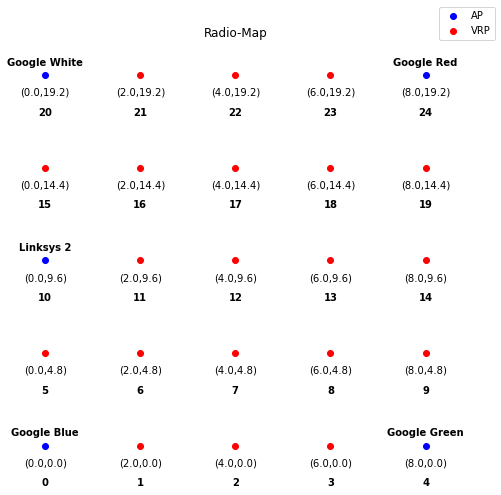

In [17]:
plt.figure(figsize=(points_x*1.5, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-5)
plt.title('Radio-Map',pad=20)
plt.axis('off')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

# Dataset Processing

In [18]:
"""
Dataset split

    - L_ap --> Training locations
    - ap_obs --> RTT Distance Observations between APs
    - L_test --> Test locations
    - vrp_test --> VRP distance measurements

We are getting data from dataset, splitting AP and VRP samples

ap_tr(target AP, reference AP, sample)
vrp_test(target VRP, reference AP, sample)
"""

"""
Full dataset
"""
dataset = np.array([split_df(locations[i]) for (i) in np.linspace(0, n_points - 1, n_points).astype(int)]).round(2)

"""
Training data
"""
ap_tr = np.array([split_df(L_ap[i]) for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)]).round(2)
n_tr = ap_tr.shape[2]

"""
Locations of test data
"""
locations_test = np.array(np.meshgrid(np.linspace(0, height, 5).round(2), np.linspace(0, width, 5).round(2))).T.reshape(-1,2)
locations_test[:, [1, 0]] = locations_test[:, [0, 1]]

"""
Coordinates corresponding to test VRPs
"""
coordinates_test = np.array(np.meshgrid(np.linspace(0, 4, 5), np.linspace(0, 4, 5))).T.reshape(-1,2)
coordinates_test[:, [1, 0]] = coordinates_test[:, [0, 1]]

points_test = []
for i in range(len(ap_list)):
  points_test.append(get_location(locations_test, [ap_list[i].x, ap_list[i].y]))

coordinates_test_ap = coordinates_test[points_test,:]
coordinates_test_vrp = np.delete(coordinates_test, points_test, 0)

"""
Test locations corresponding to APs
"""
L_test = np.delete(locations_test, points_test, 0)
n_test = L_test.shape[0]

"""
Test data
"""
vrp_test = np.array([split_df(L_test[i]) for (i) in range(L_test.shape[0])]).round(2)
n_samples_test = vrp_test.shape[2]

## Data Plot

####  Select AP and Sample

In [19]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_tr - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=0, description='Sample:', max=99)

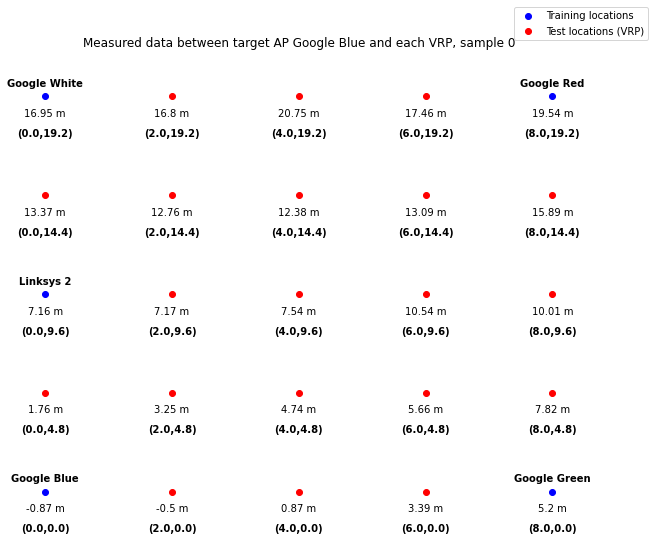

In [20]:
ap_selected = ap_dropdown.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
plt.figure(figsize=(10, 8))

plt.scatter(coordinates_test_ap[:,0], coordinates_test_ap[:,1], c='b')
plt.scatter(coordinates_test_vrp[:,0], coordinates_test_vrp[:,1], c='r')

plt.legend(labels=['Training locations','Test locations (VRP)'],loc="upper right",borderaxespad=-7)
plt.title('Measured data between target AP '+ap_selected+' and each VRP, sample '+str(sample),pad=30)
plt.axis('off')

for x,y,z in zip(coordinates_test_ap[:,0], coordinates_test_ap[:,1], ap_tr[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_ap[:,0],coordinates_test_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates_test_ap[:,0],coordinates_test_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"({L_ap[z,0]},{L_ap[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_vrp[:,0], coordinates_test_vrp[:,1], vrp_test[:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_vrp[:,0],coordinates_test_vrp[:,1], np.linspace(0, 24, 25).astype(int)):
    label = f"({L_test[z,0]},{L_test[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

# Dataset Validation

In [21]:
"""
Training check
"""
tr_check = np.array([np.array([vec_mean(ap_tr[j,i,:], n_tr)
                            for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

test_check = np.array([np.array([vec_mean(vrp_test[j,i,:], n_tr)
                            for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                            for (j) in np.linspace(0, n_test - 1, n_test).astype(int)])
"""
Euclidean distance computing
"""
d_euc = compute_euclidean_distance(locations_test)
d_euc_ap = d_euc[points_test,:]

## Validation plot

#### Select AP

In [22]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

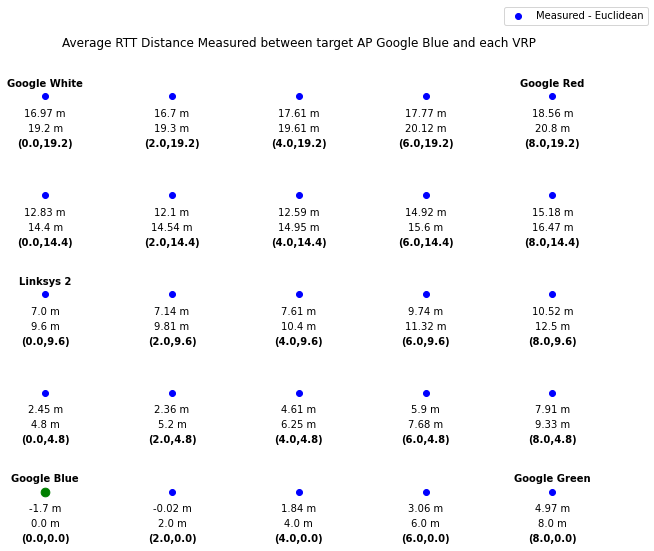

In [23]:
ap_selected = ap_dropdown.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
plt.figure(figsize=(10, 8))

plt.scatter(coordinates_test_ap[:,0], coordinates_test_ap[:,1], c='b')
plt.scatter(coordinates_test_vrp[:,0], coordinates_test_vrp[:,1], c='b')

#Target AP
plt.scatter(coordinates_test_ap[int(ap_indexes[ap_selected]),0],
           coordinates_test_ap[int(ap_indexes[ap_selected]),1], s=75, c='g', alpha=1)

plt.legend(labels=['Measured - Euclidean'],loc="upper right",borderaxespad=-7)
plt.title('Average RTT Distance Measured between target AP '+ap_selected+' and each VRP',pad=30)
plt.axis('off')

for x,y,z in zip(coordinates_test_ap[:,0], coordinates_test_ap[:,1], tr_check[:,int(ap_indexes[ap_selected])]):
    label = f"{z[0].round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_ap[:,0],coordinates_test_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"({L_ap[z,0]},{L_ap[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-50), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_vrp[:,0], coordinates_test_vrp[:,1], test_check[:,int(ap_indexes[ap_selected])]):
    label = f"{z[0].round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_vrp[:,0],coordinates_test_vrp[:,1], np.linspace(0, n_test - 1, n_test).astype(int)):
    label = f"({L_test[z,0]},{L_test[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-50), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test[:,0], coordinates_test[:,1], d_euc_ap[int(ap_indexes[ap_selected]),:]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-35), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_ap[:,0],coordinates_test_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

# Training Data Processing

## Averaging of the training data

### Data plot

In [24]:
"""
Sliding Window Mean

 - Observations vector: Training Data (ap_tr)
 - Window size: Location Data Length

"""

ap_obs = np.array([np.array([np.array([get_window_mean(ap_tr[j,i,:], k)
                                    for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                    for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                    for (k) in np.arange(1,51).astype(int)])

n_samples = ap_obs.shape[0]

####  Select AP, sample and average factor

In [25]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=1, description='Factor:', max=50, min=1)

IntSlider(value=0, description='Sample:', max=49)

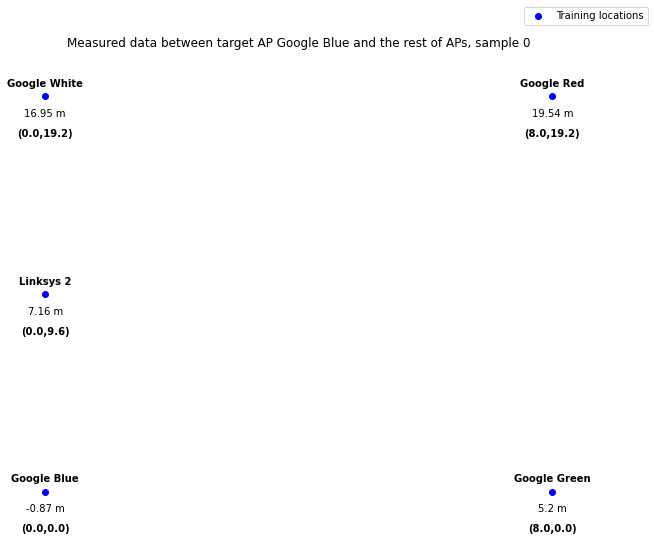

In [26]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
plt.figure(figsize=(10, 8))

plt.scatter(coordinates_test_ap[:,0], coordinates_test_ap[:,1], c='b')

plt.legend(labels=['Training locations'],loc="upper right",borderaxespad=-7)
plt.title('Measured data between target AP '+ap_selected+' and the rest of APs, sample '+str(sample),pad=30)
plt.axis('off')

for x,y,z in zip(coordinates_test_ap[:,0], coordinates_test_ap[:,1], ap_obs[factor - 1][:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_test_ap[:,0],coordinates_test_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates_test_ap[:,0],coordinates_test_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):
    label = f"({L_ap[z,0]},{L_ap[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-40), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

# Polynomial Surface Fitting

In [27]:
"""
Polynomial Surface model fitting
    
    loc --> X,Y tuple array of AP locations
    d --> AP RTT distance observations
    order --> Polinomial order
"""
def surface_fit(loc, d, order=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    loc = np.delete(loc, idx, 0)
    d = np.delete(d, idx)

    '''
    Computing polynomial surface coefficients
    '''
    if order == 1:
        A = np.c_[loc[:,0], loc[:,1], np.ones(loc.shape[0])]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    else:
        A = np.c_[np.ones(loc.shape[0]), loc[:,:2], np.prod(loc[:,:2], axis=1), loc[:,:2]**2]
        C,_,_,_ = scipy.linalg.lstsq(A, d)
    return C

In [28]:
"""
Mean RTT distance estimation
    
    x --> AP's x locations
    y --> AP's y locations
    C --> Model coefficients
"""
def sample_distance(x, y, C):
    XX = x.flatten()
    YY = y.flatten()
    
    if C.shape[0] == 3:
        fit = np.dot(np.c_[XX, YY, np.ones(XX.shape)], C).reshape(x.shape)
    else:
        fit = np.dot(np.c_[np.ones(XX.shape), XX, YY, XX*YY, XX**2, YY**2], C).reshape(x.shape)
    return fit

## Surface Fitting Models

In [29]:
"""
Plot domain
"""
X,Y = np.meshgrid(np.linspace(0, width, points_x).round(2), np.linspace(0, height, points_y).round(2))

"""
Models fitting and surface estimation
"""

models_1 = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([surface_fit(L_ap, obs[:,j,i])
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)]) 
  models_1[k] = aux

models_2 = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([surface_fit(L_ap, obs[:,j,i], 2)
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)]) 
  models_2[k] = aux

Z_1 = np.empty(n_samples, dtype=object)
for k, coeff in enumerate(models_1):
  sp = coeff.shape[1]
  aux = np.array([np.array([sample_distance(X, Y, coeff[j,i,:]) 
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  Z_1[k] = aux

Z_2 = np.empty(n_samples, dtype=object)
for k, coeff in enumerate(models_2):
  sp = coeff.shape[1]
  aux = np.array([np.array([sample_distance(X, Y, coeff[j,i,:]) 
                      for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                      for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  Z_2[k] = aux

## Surface Fitting Models Plot

#### Select AP, sample and average factor

In [30]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=1, description='Factor:', max=50, min=1)

IntSlider(value=0, description='Sample:', max=49)

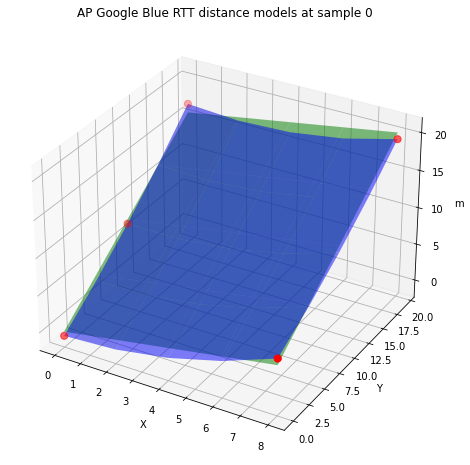

In [31]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

fig = plt.figure(figsize=(12,8))

ax = plt.axes(projection='3d')

l1 = ax.plot_surface(X, Y, Z_1[factor - 1][int(ap_indexes[ap_selected]), sample], rstride=1, cstride=1, alpha=0.5, label='linear', color='g')
l2 = ax.plot_surface(X, Y, Z_2[factor - 1][int(ap_indexes[ap_selected]), sample], rstride=1, cstride=1, alpha=0.5, label='quadratic', color='b')

ax.scatter(L_ap[:,0], L_ap[:,1], ap_obs[factor - 1][:,int(ap_indexes[ap_selected]), sample], c='r', s=50)

plt.xlabel('X')
plt.ylabel('Y')

ax.set_zlabel('m')
ax.axis('auto')

plt.title('AP '+ ap_selected +' RTT distance models at sample ' + str(sample))
plt.show()

## Mean RTT Distance vectors

In [32]:
"""
Mean RTT distance values at VRPs
    _1 --> Order 1 surface fit
    _2 --> Order 2 surface fit
"""

fit_1 = np.empty(n_samples, dtype=object)
for k, estimation in enumerate(Z_1):
  sp = estimation.shape[1]
  aux = np.reshape(estimation, (n_ap, sp, n_points, 1))
  fit_1[k] = aux

fit_2 = np.empty(n_samples, dtype=object)
for k, estimation in enumerate(Z_2):
  sp = estimation.shape[1]
  aux = np.reshape(estimation, (n_ap, sp, n_points, 1))
  fit_2[k] = aux

"""
Mean RTT observations between target AP and the rest
"""

m_ap_1 = np.empty(n_samples, dtype=object)
for k, fit in enumerate(fit_1):
  sp = fit.shape[1]
  aux = np.array([fit[:, i, points, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
  m_ap_1[k] = aux

m_ap_2 = np.empty(n_samples, dtype=object)
for k, fit in enumerate(fit_2):
  sp = fit.shape[1]
  aux = np.array([fit[:, i, points, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
  m_ap_2[k] = aux

"""
Reference points vector
"""
vrp_pts = np.delete(np.linspace(0, n_points - 1, n_points).astype(int), points, 0)

"""
Mean RTT observations between target AP and VRPs
"""

m_vrp_1 = np.empty(n_samples, dtype=object)
for k, fit in enumerate(fit_1):
  sp = fit.shape[1]
  aux = np.array([fit[:, i, vrp_pts, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
  m_vrp_1[k] = aux

m_vrp_2 = np.empty(n_samples, dtype=object)
for k, fit in enumerate(fit_2):
  sp = fit.shape[1]
  aux = np.array([fit[:, i, vrp_pts, :] for (i) in np.linspace(0, sp - 1, sp).astype(int)])
  m_vrp_2[k] = aux

#### Select AP, sample and average factor

In [33]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=0, description='Factor:', max=50)

IntSlider(value=0, description='Sample:', max=49)

## Order 1 PSFM Mean RTT Distance Plot

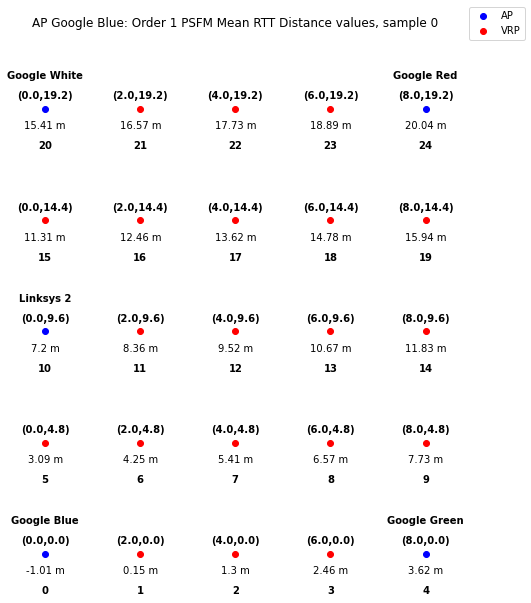

In [34]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(points_x*1.5, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 1 PSFM Mean RTT Distance values, sample '+str(sample),pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{fit_1[factor - 1][int(ap_indexes[ap_selected]),sample,z][0].round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

## Order 2 PSFM Mean RTT Distance Plot

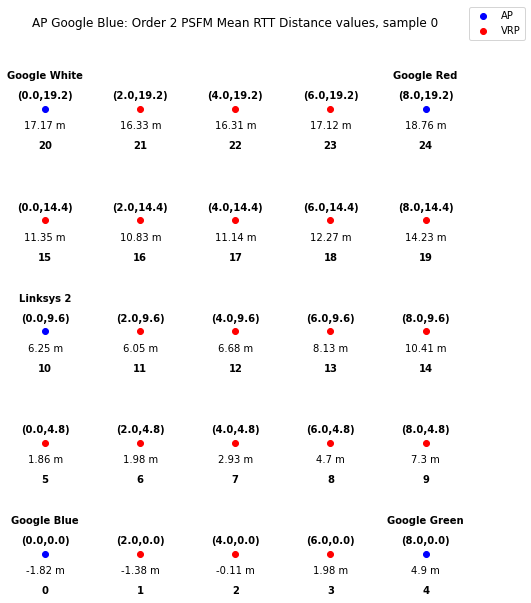

In [35]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

plt.figure(figsize=(points_x*1.5, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+': Order 2 PSFM Mean RTT Distance values, sample '+str(sample),pad=60)
plt.axis('off')

for x,y,z in zip(coordinates[:,0], coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"{fit_2[factor - 1][int(ap_indexes[ap_selected]),sample,z][0].round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

    label = f"{z}"

    plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-40), # distance from text to points (x,y)
                  ha='center',
                  weight='bold') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

# Gaussian Process Regression

## Kernel definition

In [36]:
"""
Gaussian Process Kernel definition

Kernel parameters:
    - L --> Length Scale
    - sigma_f --> Constant Kernel Amplitude
"""

def kernel_function(x, y, sigma_f=1, l=1):

    """ Squared Exponential kernel function """
    kernel = sigma_f * np.exp(- (np.linalg.norm(x - y)**2) / (2 * l**2))
    return kernel

## Hyperparameter optimization

In [37]:
"""
Hyperparameter optimization of sigma_f and length-scale

    loc --> AP locations
    mean --> RTT distance observations between APs
"""
def gp_fit(loc, mean):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(mean)).T[0]
    loc = np.delete(loc, idx, 0)
    mean = np.delete(mean, idx)

    gp.fit(loc, mean)

    l = gp.kernel_.get_params().get('k2__length_scale')
    sigma_f = gp.kernel_.get_params().get('k1__constant_value')
    return l, sigma_f

In [38]:
"""
Gaussian Process Fit using scikit-learn GPR
"""
sigma_n = 0.5

kernel = ConstantKernel(constant_value=100.0,constant_value_bounds=(1e-3, 1e3)) \
            * RBF(length_scale=10.0, length_scale_bounds=(1e-3, 1e3))

gp = GaussianProcessRegressor(kernel=kernel, alpha=sigma_n**2, n_restarts_optimizer=10)

hyper_params = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([gp_fit(L_ap, obs[:,j,i]) 
                        for (i) in np.linspace(0, sp - 1, sp).astype(int)]) 
                        for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  hyper_params[k] = aux

## Covariance matrices

### Covariance matrix computing

In [39]:
def compute_k_matrix(loc, obs, sigma_f=1, l=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(obs)).T[0]
    loc = np.delete(loc, idx, 0)

    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K = K(L, L)
    """
    
    K = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(loc, loc)]
    K = np.array(K).reshape(loc.shape[0], loc.shape[0])

    return K

In [40]:
def compute_k_star_matrix(loc, ref, obs, sigma_f=1, l=1):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(obs)).T[0]
    loc = np.delete(loc, idx, 0)

    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K_star = K(L^*, L)
    """
    K_star = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(ref, loc)]
    K_star = np.array(K_star).reshape(ref.shape[0], loc.shape[0])

    return K_star

In [41]:
def compute_k_star2_matrix(ref, sigma_f=1, l=1):
    """
    Compute components of the covariance matrix of the joint distribution.
    
    We follow the notation:
        - K_star2 = K(L^*, L^*)
    """

    K_star2 = [kernel_function(i, j, sigma_f=sigma_f, l=l) for (i, j) in itertools.product(ref, ref)]
    K_star2 = np.array(K_star2).reshape(ref.shape[0], ref.shape[0])
    
    return K_star2

In [42]:
"""
Covariance matrices and regressor objects computing:

    - Covariance matrices: K, K_star, K_star2
"""

k_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux2 = np.empty(sp, dtype=object)
  for (i) in np.linspace(0, sp - 1, sp).astype(int):
    aux = np.array([compute_k_matrix(L_ap, 
                                    obs[:,j,i],
                                    sigma_f=hyper_params[k][j,i][1], 
                                    l=hyper_params[k][j,i][0]) 
                    for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)], dtype=object)
    aux2[i] = aux
  k_array[k] = aux2

k_star2_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux2 = np.empty(sp, dtype=object)
  for (i) in np.linspace(0, sp - 1, sp).astype(int):
    aux = np.array([compute_k_star2_matrix(L_vrp,
                                           sigma_f=hyper_params[k][j,i][1], 
                                           l=hyper_params[k][j,i][0]) 
                    for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)], dtype=object)
    aux2[i] = aux
  k_star2_array[k] = aux2

k_star_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux3 = np.empty(sp, dtype=object)
  for (i) in np.linspace(0, sp - 1, sp).astype(int):
    aux2 = np.empty(n_ap, dtype=object)
    for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int):
      aux = compute_k_star_matrix(L_ap,
                                  L_vrp,
                                  obs[:,j,i],
                                  sigma_f=hyper_params[k][j,i][1], 
                                  l=hyper_params[k][j,i][0])
      aux2[j] = aux
    aux3[i] = aux2
  k_star_array[k] = aux3

### Multivariate Gaussian Process Dimension Check

#### Select AP, sample and average factor

In [43]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=0, description='Factor:', max=50)

IntSlider(value=0, description='Sample:', max=49)

In [44]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Multivariate Joint Distribution Check: G matrix
"""

k_array_len = k_array[factor - 1][sample][int(ap_indexes[ap_selected])].shape[0]
k_star2_array_len = k_star2_array[factor -1][sample][int(ap_indexes[ap_selected])].shape[0]

a = np.concatenate((k_array[factor - 1][sample][int(ap_indexes[ap_selected])] 
                    + (sigma_n**2)*np.eye(k_array_len), 
                    k_star_array[factor - 1][sample][int(ap_indexes[ap_selected])]), axis=0)
print(a.shape)
b = np.concatenate((k_star_array[factor - 1][sample][int(ap_indexes[ap_selected])].T, k_star2_array[factor - 1][sample][int(ap_indexes[ap_selected])]), axis=0)
print(b.shape)
G = np.concatenate((a, b), axis=1)
print(G.shape)
G.shape == (k_array_len + k_star2_array_len, k_array_len + k_star2_array_len)

(25, 5)
(25, 20)
(25, 25)


True

### Covariance matrices plot

#### Select AP, sample and average factor

In [45]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=0, description='Factor:', max=50)

IntSlider(value=0, description='Sample:', max=49)

#### K Matrix Plot

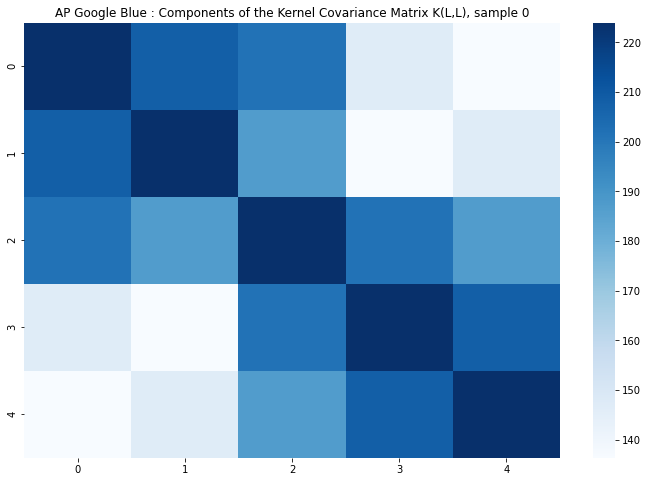

In [46]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Kernel Covariance Matrix K(L,L)
"""
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=k_array[factor - 1][sample][int(ap_indexes[ap_selected])].astype(float), cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L,L), sample '+str(sample))
plt.show()

#### K Star Squared Matrix Plot

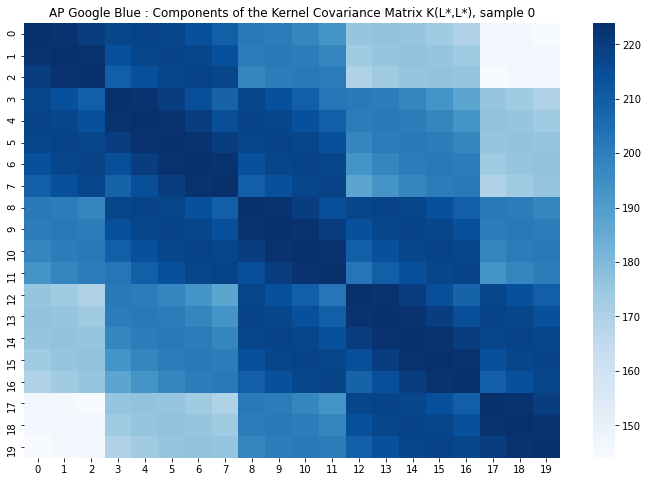

In [47]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Kernel Covariance Matrix K(L*,L*)
"""
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=k_star2_array[factor - 1][sample][int(ap_indexes[ap_selected])].astype(float), cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L*), sample '+str(sample))
plt.show()

#### K Star Matrix Plot

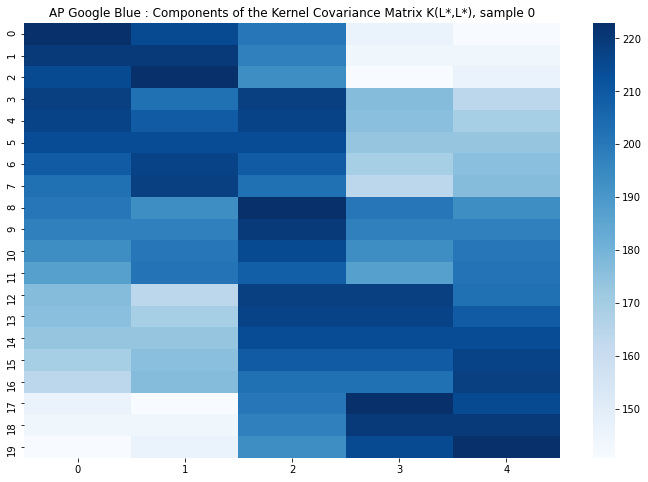

In [49]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Kernel Covariance Matrix K(L*,L)
"""
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(data=k_star_array[factor - 1][sample][int(ap_indexes[ap_selected])].astype(float), cmap='Blues', ax=ax)
ax.set(title='AP '+ap_selected+' : Components of the Kernel Covariance Matrix K(L*,L*), sample '+str(sample))
plt.show()

# PSFM GPR Interpolation

## Interpolation Computing

In [50]:
def psfm_gpr_mean(m, m_star, d, K, K_star, sigma_n):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    m = np.delete(m, idx)
    d = np.delete(d, idx)

    """Compute gaussian regression parameters."""
    s_bar_star = (m_star.reshape([m_star.shape[0], 1]) 
        + np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), d.reshape([d.shape[0], 1]) - m.reshape([m.shape[0], 1]))))
    
    return s_bar_star.reshape(n_vrp)

In [51]:
def zero_mean_gpr_mean(d, K, K_star, sigma_n):
    '''
    Clear nan values
    '''
    idx = np.argwhere(np.isnan(d)).T[0]
    d = np.delete(d, idx)

    """Compute gaussian regression parameters."""
    s_bar_star = np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), d.reshape([d.shape[0], 1])))
    
    return s_bar_star.reshape(n_vrp)

In [52]:
def zero_mean_gpr_cov(K, K_star2, K_star, sigma_n):

    """Compute gaussian regression parameters."""
    cov_s_star = K_star2 - np.dot(K_star, np.dot(np.linalg.inv(K + (sigma_n**2)*np.eye(K.shape[0])), K_star.T))
    
    return cov_s_star

In [53]:
"""
Zero-Mean Gaussian Process interpolations
"""
mean_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([zero_mean_gpr_mean(obs[:,j,i], 
                                               k_array[k][i][j].astype(float), 
                                               k_star_array[k][i][j].astype(float), 
                                               sigma_n).reshape(n_vrp,1)
                            for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  mean_array[k] = aux

var_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([np.diag(zero_mean_gpr_cov(k_array[k][i][j].astype(float), 
                                                      k_star2_array[k][i][j].astype(float), 
                                                      k_star_array[k][i][j].astype(float), 
                                                      sigma_n)).reshape(n_vrp,1)
                            for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  var_array[k] = aux

"""
Order 1 PSFM Gaussian Process interpolations
"""
mean_psfm_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([psfm_gpr_mean(m_ap_1[k][i,j], 
                                          m_vrp_1[k][i,j], 
                                          obs[:,j,i], 
                                          k_array[k][i][j].astype(float), 
                                          k_star_array[k][i][j].astype(float), 
                                          sigma_n).reshape(n_vrp,1)
                              for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                              for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  mean_psfm_array[k] = aux

"""
Order 2 PSFM Gaussian Process interpolations
"""
mean_psfm2_array = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  sp = obs.shape[2]
  aux = np.array([np.array([psfm_gpr_mean(m_ap_2[k][i,j], 
                                          m_vrp_2[k][i,j], 
                                          obs[:,j,i], 
                                          k_array[k][i][j].astype(float), 
                                          k_star_array[k][i][j].astype(float), 
                                          sigma_n).reshape(n_vrp,1)
                               for (i) in np.linspace(0, sp - 1, sp).astype(int)])
                               for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  mean_psfm2_array[k] = aux

## Interpolation Plots

#### Select AP, sample and average factor

In [54]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Google White', 'Go…

IntSlider(value=1, description='Factor:', max=50, min=1)

IntSlider(value=0, description='Sample:', max=49)

## Zero-Mean GPR

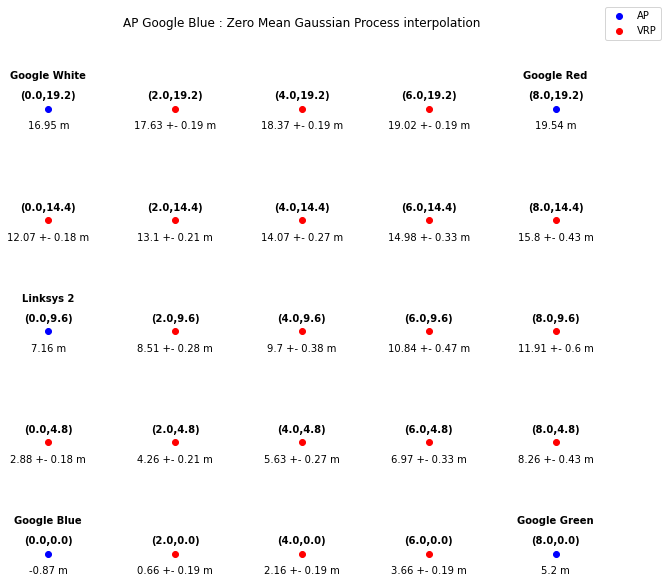

In [55]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*2, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero Mean Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[factor -1][:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(mean_array[factor - 1][int(ap_indexes[ap_selected]), sample])):
    label = f"{mean_array[factor - 1][int(ap_indexes[ap_selected]), sample][x,0].round(2)} +- {var_array[factor - 1][int(ap_indexes[ap_selected]), sample][x,0].round(2)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

## First Order PSFM GPR

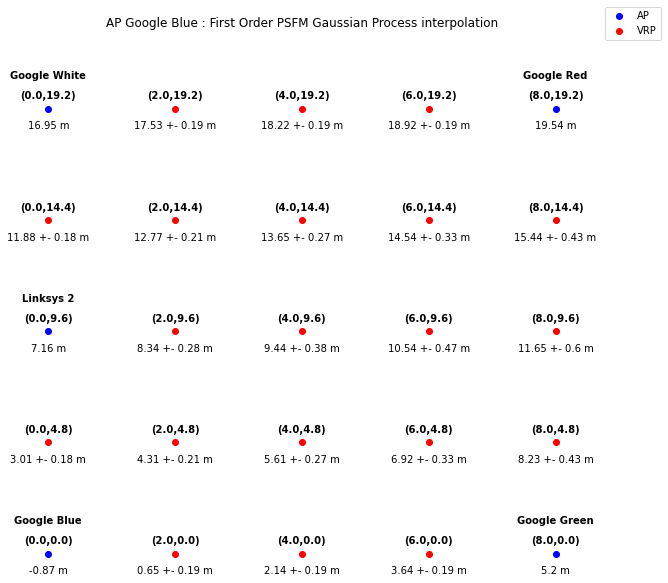

In [56]:
ap_selected = ap_dropdown.value
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
First Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*2, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : First Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[factor - 1][:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(mean_array[factor - 1][int(ap_indexes[ap_selected]),sample])):
    label = f"{mean_psfm_array[factor - 1][int(ap_indexes[ap_selected]),sample][x,0].round(2)} +- {var_array[factor - 1][int(ap_indexes[ap_selected]), sample][x,0].round(2)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

## Second Order PSFM GPR

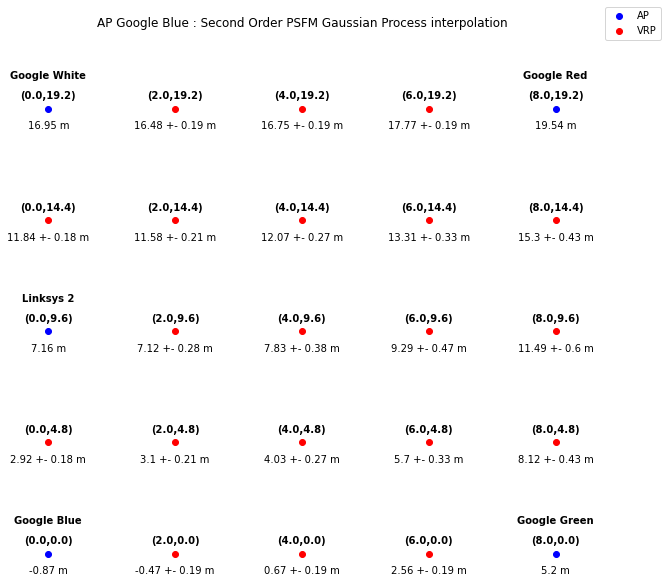

In [57]:
ap_selected = ap_dropdown
factor = factor_slider.value
sample = sample_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

"""
Second Order PSFM Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*2, points_y*1.8))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Second Order PSFM Gaussian Process interpolation',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs[factor - 1][:,int(ap_indexes[ap_selected]),sample]):
    label = f"{z.round(2)} m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x in range(len(mean_psfm2_array[factor - 1][int(ap_indexes[ap_selected]),sample])):
    label = f"{mean_psfm2_array[factor - 1][int(ap_indexes[ap_selected]),sample][x,0].round(2)} +- {var_array[factor - 1][int(ap_indexes[ap_selected]),sample][x,0].round(2)} m"

    plt.annotate(label, # this is the text
                 (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

# Fingerprinting Database Construction

#### Select sample and average factor

In [58]:
factor_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

sample_slider = widgets.IntSlider(
    value=0,
    min=0,
    max=n_samples - 1,
    step=1,
    description='Sample:',
    diabled=False
)

display(sample_slider)

IntSlider(value=1, description='Factor:', max=50, min=1)

IntSlider(value=0, description='Sample:', max=49)

## Zero Mean GPR Fingerprinting Database plot

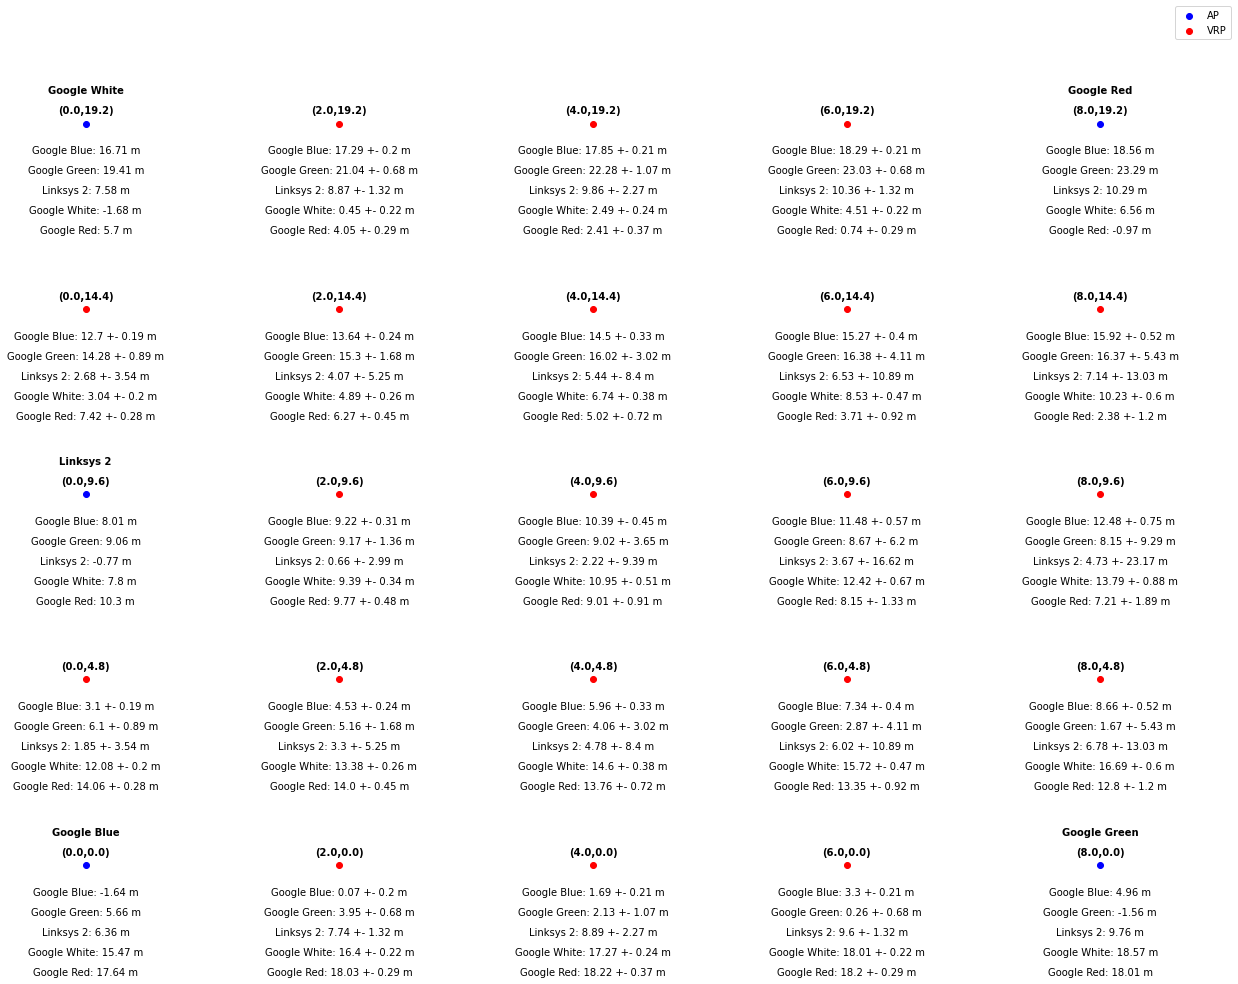

In [59]:
factor = factor_slider.value
sample = factor_slider.value

plt.figure(figsize=(points_x*4, 3*n_ap))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center
                 
for x in range(ap_obs[factor - 1].shape[0]):
    for y in range(ap_obs[factor - 1].shape[0]):
        label = f"{ap_labels[y]}: {ap_obs[factor - 1][x,y,sample].round(2)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(mean_array[factor - 1].shape[2]):
    for y in range(ap_obs[factor - 1].shape[0]):
        label = f"{ap_labels[y]}: {mean_array[factor - 1][y,sample,x,0].round(2)} +- {var_array[factor -1][y,sample,x,0].round(2)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

## First Order PSFM GPR Fingerprinting Database plot

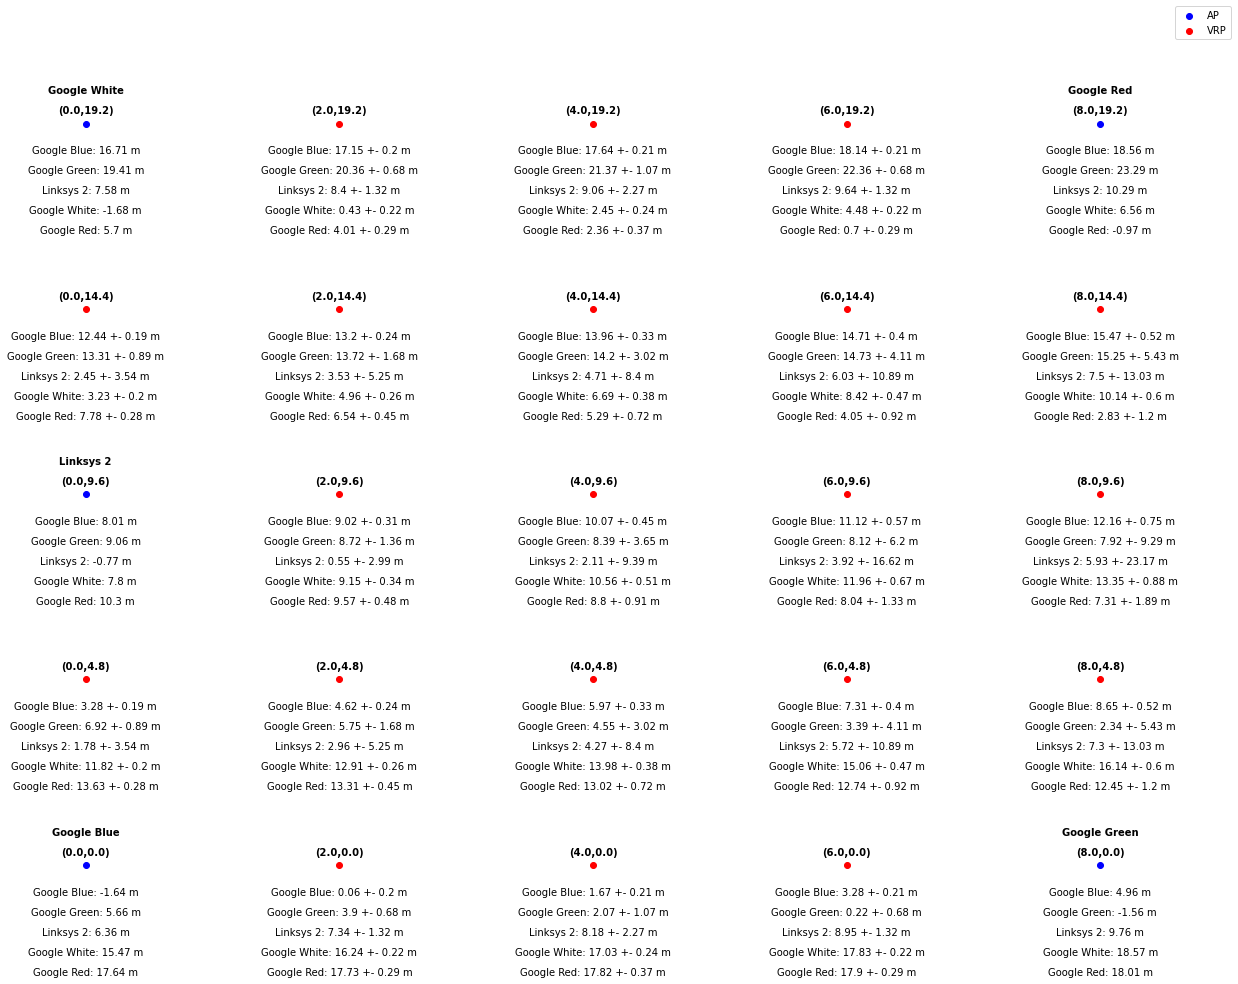

In [60]:
factor = factor_slider.value
sample = factor_slider.value

plt.figure(figsize=(points_x*4, 3*n_ap))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center
                 
for x in range(ap_obs[factor - 1].shape[0]):
    for y in range(ap_obs[factor - 1].shape[0]):
        label = f"{ap_labels[y]}: {ap_obs[factor - 1][x,y,sample].round(2)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(mean_psfm_array[factor - 1].shape[2]):
    for y in range(ap_obs[factor - 1].shape[0]):
        label = f"{ap_labels[y]}: {mean_psfm_array[factor - 1][y,sample,x,0].round(2)} +- {var_array[factor - 1][y,sample,x,0].round(2)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

## Second Order PSFM GPR Fingerprinting Database plot

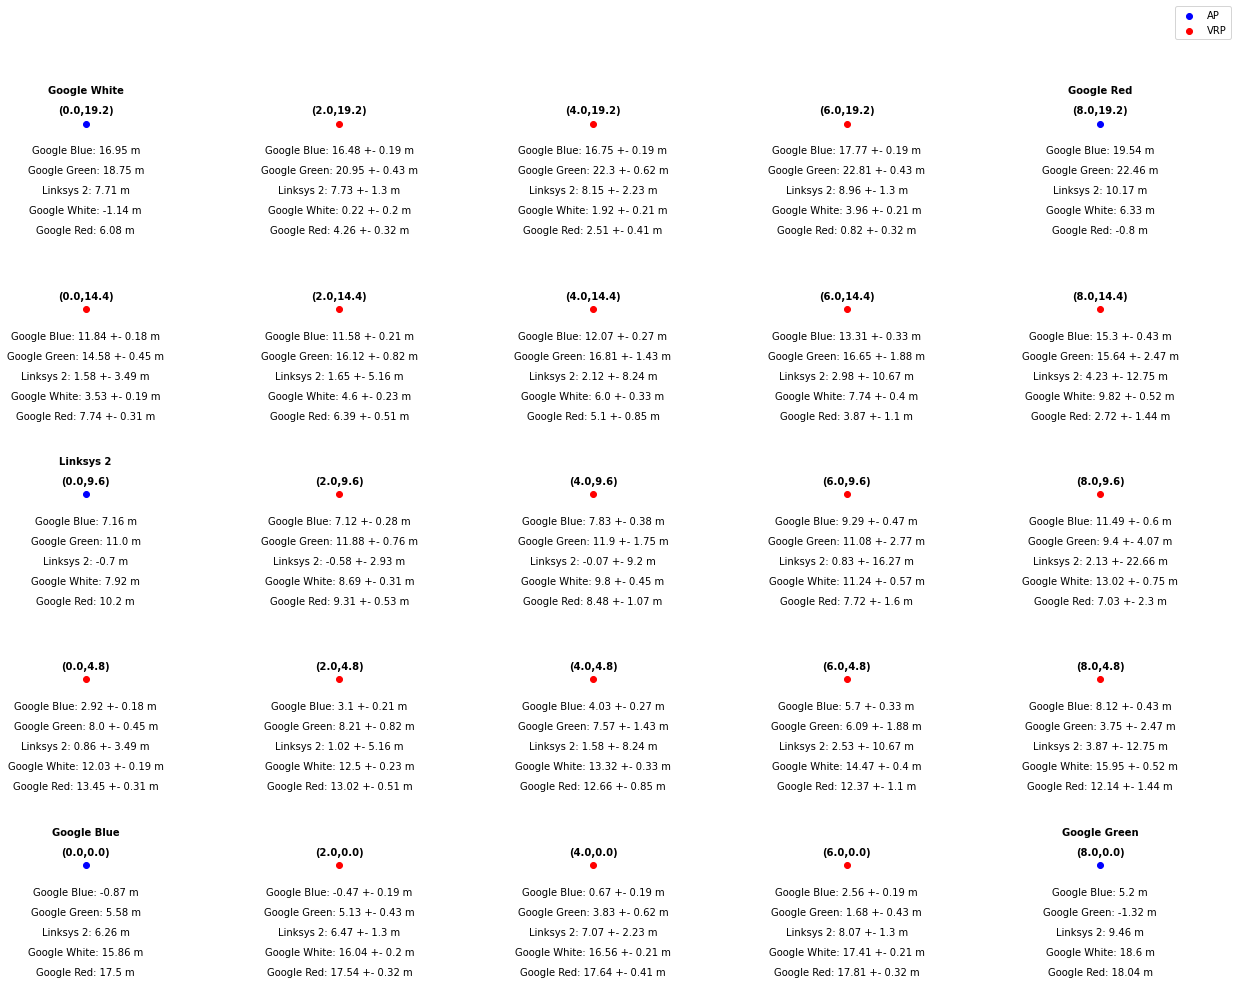

In [61]:
factor = factor_slider.value
sample = sample_slider.value

plt.figure(figsize=(points_x*4, 3*n_ap))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')


for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center
                 
for x in range(ap_obs[factor - 1].shape[0]):
    for y in range(ap_obs[factor - 1].shape[0]):
        label = f"{ap_labels[y]}: {ap_obs[factor - 1][x,y,sample].round(2)} m"

        plt.annotate(label, # this is the text
                    (coordinates_ap[x,0],coordinates_ap[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

for x in range(mean_psfm2_array[factor - 1].shape[2]):
    for y in range(ap_obs[factor - 1].shape[0]):
        label = f"{ap_labels[y]}: {mean_psfm2_array[factor - 1][y,sample,x,0].round(2)} +- {var_array[factor - 1][y,sample,x,0].round(2)} m"

        plt.annotate(label, # this is the text
                    (coordinates_vrp[x,0],coordinates_vrp[x,1]), # this is the point to label
                    textcoords="offset points", # how to position the text
                    xytext=(0,-30-y*20), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

# Confidence Interval

In [60]:
"""
Complete dataset
"""
dataset_interval = np.array([np.array([mean_confidence_interval(dataset[i,j,:])
                               for (i) in np.linspace(0, n_points - 1, n_points).astype(int)])
                               for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

"""
Observations between AP's
"""
ap_obs_interval = np.empty(n_samples, dtype=object)
for k, obs in enumerate(ap_obs):
  aux = np.array([np.array([mean_confidence_interval(obs[i,j,:])
                  for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                  for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  ap_obs_interval[k] = aux

"""
Measured data at each VRP
"""
vrp_test_interval = np.array([np.array([mean_confidence_interval(vrp_test[i,j,:])
                               for (i) in np.linspace(0, n_test - 1, n_test).astype(int)])
                               for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])

"""
Zero-Mean GPR Estimations
"""
zero_mean_interval = np.empty(n_samples, dtype=object)
for k, mean in enumerate(mean_array):
  sp = mean.shape[1]
  aux = np.array([np.array([mean_confidence_interval(mean[j,:,i].reshape(sp)) 
                            for (i) in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  zero_mean_interval[k] = aux

"""
First Order PSFM GPR Estimations
"""
psfm_interval = np.empty(n_samples, dtype=object)
for k, mean in enumerate(mean_psfm_array):
  sp = mean.shape[1]
  aux = np.array([np.array([mean_confidence_interval(mean[j,:,i].reshape(sp)) 
                            for (i) in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  psfm_interval[k] = aux

"""
Second Order PSFM GPR Estimations
"""
psfm2_interval = np.empty(n_samples, dtype=object)
for k, mean in enumerate(mean_psfm2_array):
  sp = mean.shape[1]
  aux = np.array([np.array([mean_confidence_interval(mean[j,:,i].reshape(sp)) 
                            for (i) in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                            for (j) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
  psfm2_interval[k] = aux

#### Select AP and average factor

In [61]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Linksys 4', 'Googl…

IntSlider(value=1, description='Factor:', max=50, min=1)

## Zero-Mean GPR Interval Plot

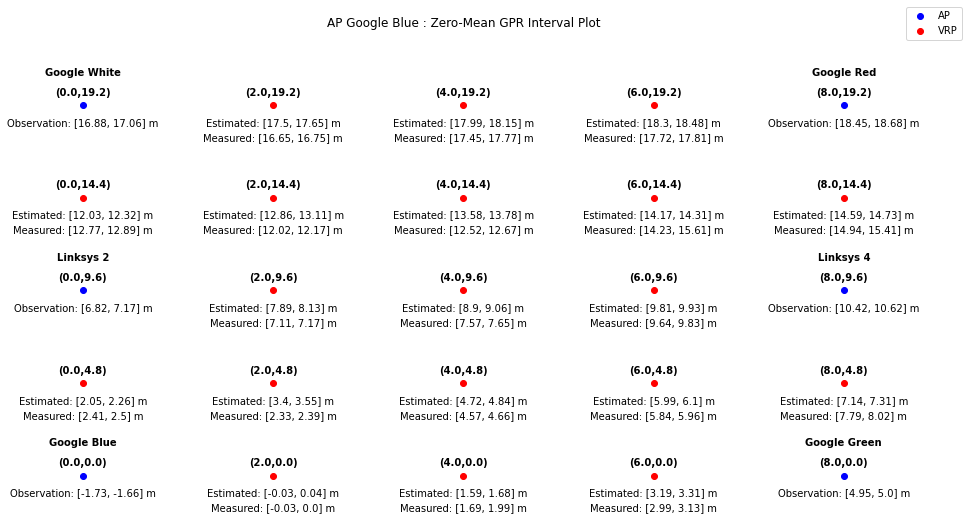

In [62]:
ap_selected = ap_dropdown.value
factor = factor_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*3, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Zero-Mean GPR Interval Plot',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs_interval[factor - 1][int(ap_indexes[ap_selected]),:]):
    label = f"Observation: [{z[1].round(2)}, {z[2].round(2)}] m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_vrp[:,0], coordinates_vrp[:,1], zero_mean_interval[factor - 1][int(ap_indexes[ap_selected]),:]):
    label = f"Estimated: [{z[1].round(2)}, {z[2].round(2)}] m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_vrp[:,0], coordinates_vrp[:,1], np.linspace(0, n_vrp - 1, n_vrp).astype(int)):
    
    try:
      loc = get_location(L_test, L_vrp[z])
    except:
      loc = math.nan
    
    if not(isnan(loc)):
      meas = vrp_test_interval[int(ap_indexes[ap_selected]),loc]
      label = f"Measured: [{meas[1].round(2)}, {meas[2].round(2)}] m"

      plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-35), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

## First Order PSFM GPR Interval Plot

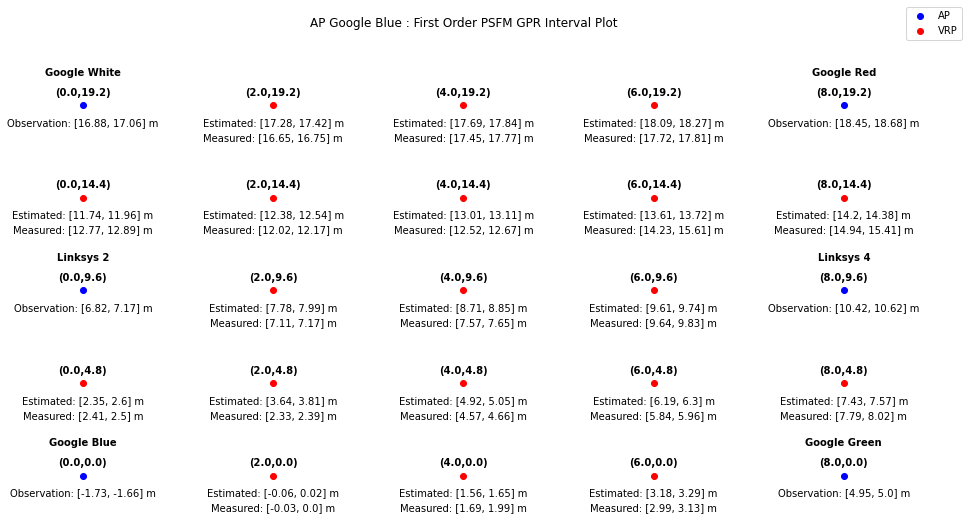

In [63]:
ap_selected = ap_dropdown.value
factor = factor_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*3, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : First Order PSFM GPR Interval Plot',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs_interval[factor - 1][int(ap_indexes[ap_selected]),:]):
    label = f"Observation: [{z[1].round(2)}, {z[2].round(2)}] m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_vrp[:,0], coordinates_vrp[:,1], psfm_interval[factor - 1][int(ap_indexes[ap_selected]),:]):
    label = f"Estimated: [{z[1].round(2)}, {z[2].round(2)}] m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_vrp[:,0], coordinates_vrp[:,1], np.linspace(0, n_vrp - 1, n_vrp).astype(int)):
    
    try:
      loc = get_location(L_test, L_vrp[z])
    except:
      loc = math.nan
    
    if not(isnan(loc)):
      meas = vrp_test_interval[int(ap_indexes[ap_selected]),loc]
      label = f"Measured: [{meas[1].round(2)}, {meas[2].round(2)}] m"

      plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-35), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

## Second Order PSFM GPR Interval Plot

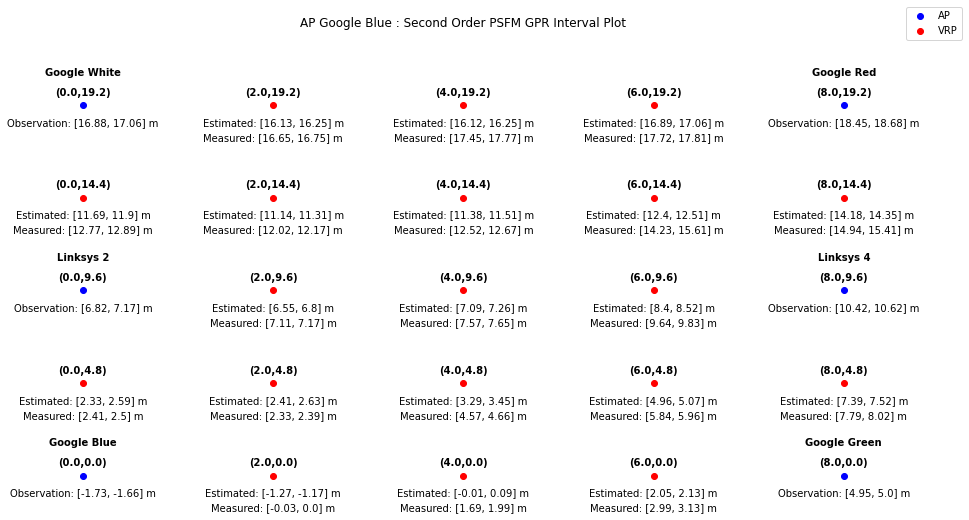

In [64]:
ap_selected = ap_dropdown.value
factor = factor_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]
  
"""
Zero Mean Gaussian Process interpolation:
    
    s_bar_star --> Mean estimated value for each VRP
    cov_s_star --> Posterior covariance matrix
    var_s_star --> VRP estimation variance
"""

plt.figure(figsize=(points_x*3, points_y*1.5))

plt.scatter(coordinates_ap[:,0], coordinates_ap[:,1], c='b')
plt.scatter(coordinates_vrp[:,0], coordinates_vrp[:,1], c='r')

plt.legend(labels=['AP','VRP'],loc="upper right",borderaxespad=-8)
plt.title('AP '+ap_selected+' : Second Order PSFM GPR Interval Plot',pad=60)
plt.axis('off')

for x,y,z in zip(coordinates_ap[:,0], coordinates_ap[:,1], ap_obs_interval[factor - 1][int(ap_indexes[ap_selected]),:]):
    label = f"Observation: [{z[1].round(2)}, {z[2].round(2)}] m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_vrp[:,0], coordinates_vrp[:,1], psfm2_interval[factor - 1][int(ap_indexes[ap_selected]),:]):
    label = f"Estimated: [{z[1].round(2)}, {z[2].round(2)}] m"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_vrp[:,0], coordinates_vrp[:,1], np.linspace(0, n_vrp - 1, n_vrp).astype(int)):
    
    try:
      loc = get_location(L_test, L_vrp[z])
    except:
      loc = math.nan
    
    if not(isnan(loc)):
      meas = vrp_test_interval[int(ap_indexes[ap_selected]),loc]
      label = f"Measured: [{meas[1].round(2)}, {meas[2].round(2)}] m"

      plt.annotate(label, # this is the text
                  (x,y), # this is the point to label
                  textcoords="offset points", # how to position the text
                  xytext=(0,-35), # distance from text to points (x,y)
                  ha='center') # horizontal alignment can be left, right or center

for x,y,z in zip(coordinates_ap[:,0],coordinates_ap[:,1], np.linspace(0, n_ap - 1, n_ap).astype(int)):

    label = f"{ap_labels[z]}"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,30), # distance from text to points (x,y)
                 ha='center', # horizontal alignment can be left, right or center
                 weight='bold')

for x,y,z in zip(coordinates[:,0],coordinates[:,1], np.linspace(0, n_points - 1, n_points).astype(int)):
    label = f"({locations[z,0]},{locations[z,1]})"

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 weight='bold') # horizontal alignment can be left, right or center

# Confidence Interval Overlap

In [65]:
"""
Integer value if estimation and measure ranges overlap

- 1: Ranges overlap
- 0: Ranges not overlap

"""

"""
Zero-Mean GPR Estimation
"""
zero_mean_interval_overlap = np.array([np.array([np.array([fits_interval(zero_mean_interval[k][i,j], vrp_test_interval[i,j])
                                            for (j) in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                                            for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                            for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int)])

"""
First Order PSFM GPR Estimation
"""
psfm_interval_overlap = np.array([np.array([np.array([fits_interval(psfm_interval[k][i,j], vrp_test_interval[i,j])
                                            for (j) in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                                            for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                            for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int)])

"""
Second Order PSFM GPR Estimation
"""
psfm2_interval_overlap = np.array([np.array([np.array([fits_interval(psfm2_interval[k][i,j], vrp_test_interval[i,j])
                                            for (j) in np.linspace(0, n_vrp - 1, n_vrp).astype(int)])
                                            for (i) in np.linspace(0, n_ap - 1, n_ap).astype(int)])
                                            for (k) in np.linspace(0, n_samples - 1, n_samples).astype(int)])

## Location Heatmap

#### Select AP and average factor

In [66]:
ap_dropdown = widgets.Dropdown(
    options=ap_labels.values(),
    value=ap_labels[0],
    description='Access Point:',
    disabled=False,
)

display(ap_dropdown)

factor_slider = widgets.IntSlider(
    value=0,
    min=1,
    max=n_tr/2,
    step=1,
    description='Factor:',
    diabled=False
)

display(factor_slider)

Dropdown(description='Access Point:', options=('Google Blue', 'Google Green', 'Linksys 2', 'Linksys 4', 'Googl…

IntSlider(value=1, description='Factor:', max=50, min=1)

### Simple

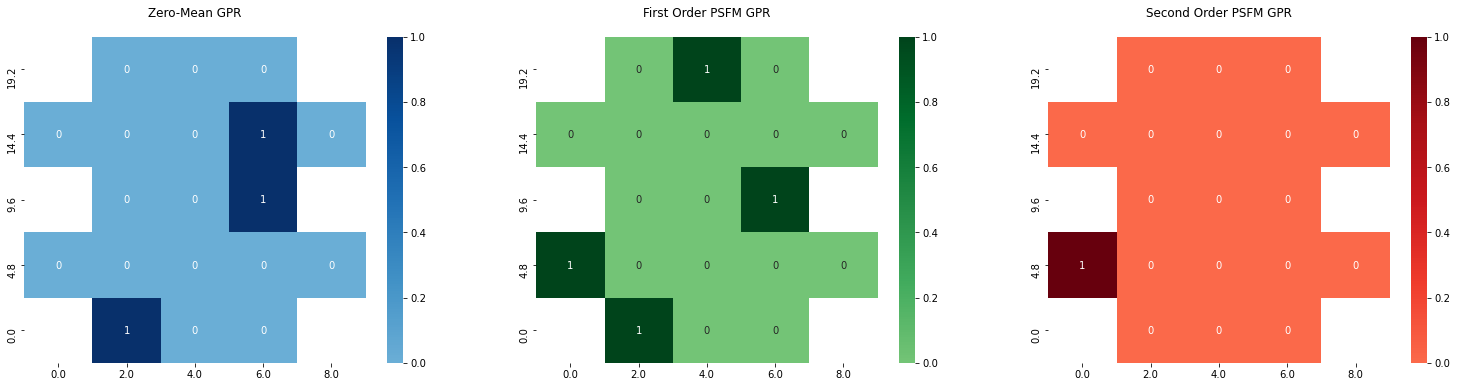

In [67]:
ap_selected = ap_dropdown.value
factor = factor_slider.value

try:
  ap_indexes[ap_selected]
except:
  ap_selected = ap_labels[0]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(26,6))

ax1.set_title("Zero-Mean GPR", pad=20)
ax2.set_title("First Order PSFM GPR", pad=20)
ax3.set_title("Second Order PSFM GPR", pad=20)

aux = np.empty(n_points)
if(zero_mean_interval_overlap[factor - 1][int(ap_indexes[ap_selected])].shape[0] == (n_points - n_ap)):
  for i in range(n_vrp):
    aux[get_location(locations, L_vrp[i])] = zero_mean_interval_overlap[factor - 1][int(ap_indexes[ap_selected])][i]
  for p in points:
    aux[p] = -1
    
aux = aux.astype(float)
aux[aux < 0] = np.nan
sns.heatmap(data=np.flip(aux.reshape(5,5), 0), cmap='Blues', 
            ax=ax1, annot=True, xticklabels = np.linspace(0, width, points_x).round(2),
            yticklabels = ['19.2','14.4','9.6','4.8','0.0'], center=0)

if(psfm_interval_overlap[factor - 1][int(ap_indexes[ap_selected])].shape[0] == (n_points - n_ap)):
  for i in range(n_vrp):
    aux[get_location(locations, L_vrp[i])] = psfm_interval_overlap[factor - 1][int(ap_indexes[ap_selected])][i]
  for p in points:
    aux[p] = -1

aux = aux.astype(float)
aux[aux < 0] = np.nan
sns.heatmap(data=np.flip(aux.reshape(5,5), 0), cmap='Greens', 
            ax=ax2, annot=True, xticklabels = np.linspace(0, width, points_x).round(2),
            yticklabels = ['19.2','14.4','9.6','4.8','0.0'], center=0)

if(psfm2_interval_overlap[factor - 1][int(ap_indexes[ap_selected])].shape[0] == (n_points - n_ap)):
  for i in range(n_vrp):
    aux[get_location(locations, L_vrp[i])] = psfm2_interval_overlap[factor - 1][int(ap_indexes[ap_selected])][i]
  for p in points:
    aux[p] = -1

aux = aux.astype(float)
aux[aux < 0] = np.nan
sns.heatmap(data=np.flip(aux.reshape(5,5), 0), cmap='Reds', 
            ax=ax3, annot=True, xticklabels = np.linspace(0, width, points_x).round(2),
            yticklabels = ['19.2','14.4','9.6','4.8','0.0'], center=0)

plt.show()

### Agreggated

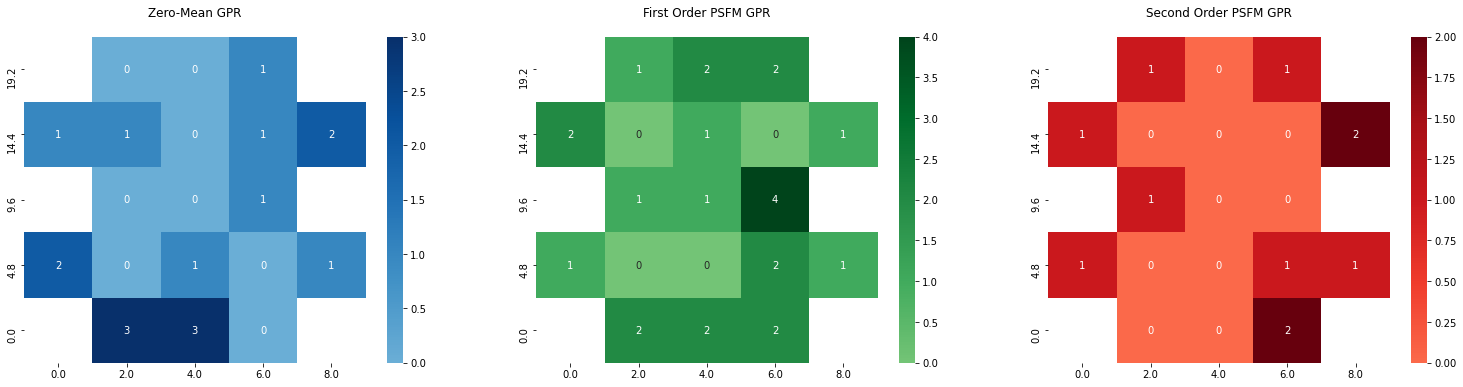

In [68]:
factor = factor_slider.value

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(26,6))

ax1.set_title("Zero-Mean GPR", pad=20)
ax2.set_title("First Order PSFM GPR", pad=20)
ax3.set_title("Second Order PSFM GPR", pad=20)

aux = np.empty((n_ap, n_points))
if(zero_mean_interval_overlap[factor - 1].shape[1] == (n_points - n_ap)):
  for i in range(n_vrp):
    aux[:,get_location(locations, L_vrp[i])] = zero_mean_interval_overlap[factor - 1][:,i]
  for p in points:
    aux[:,p] = -1

aux = aux.astype(float)
aux[aux < 0] = np.nan
sns.heatmap(data=np.flip(np.sum(aux, axis=0).reshape(5,5), 0), cmap='Blues', 
            ax=ax1, annot=True, xticklabels = np.linspace(0, width, points_x).round(2),
            yticklabels = ['19.2','14.4','9.6','4.8','0.0'], center=0)

if(psfm_interval_overlap[factor - 1].shape[1] == (n_points - n_ap)):
  for i in range(n_vrp):
    aux[:,get_location(locations, L_vrp[i])] = psfm_interval_overlap[factor - 1][:,i]
  for p in points:
    aux[:,p] = -1

aux = aux.astype(float)
aux[aux < 0] = np.nan
sns.heatmap(data=np.flip(np.sum(aux, axis=0).reshape(5,5), 0), cmap='Greens', 
            ax=ax2, annot=True, xticklabels = np.linspace(0, width, points_x).round(2),
            yticklabels = ['19.2','14.4','9.6','4.8','0.0'], center=0)

if(psfm2_interval_overlap[factor - 1].shape[1] == (n_points - n_ap)):
  for i in range(n_vrp):
    aux[:,get_location(locations, L_vrp[i])] = psfm2_interval_overlap[factor - 1][:,i]
  for p in points:
    aux[:,p] = -1
  
aux = aux.astype(float)
aux[aux < 0] = np.nan
sns.heatmap(data=np.flip(np.sum(aux, axis=0).reshape(5,5), 0), cmap='Reds', 
            ax=ax3, annot=True, xticklabels = np.linspace(0, width, points_x).round(2),
            yticklabels = ['19.2','14.4','9.6','4.8','0.0'], center=0)

plt.show()

## Bar Plot

### Simple/Aggregated

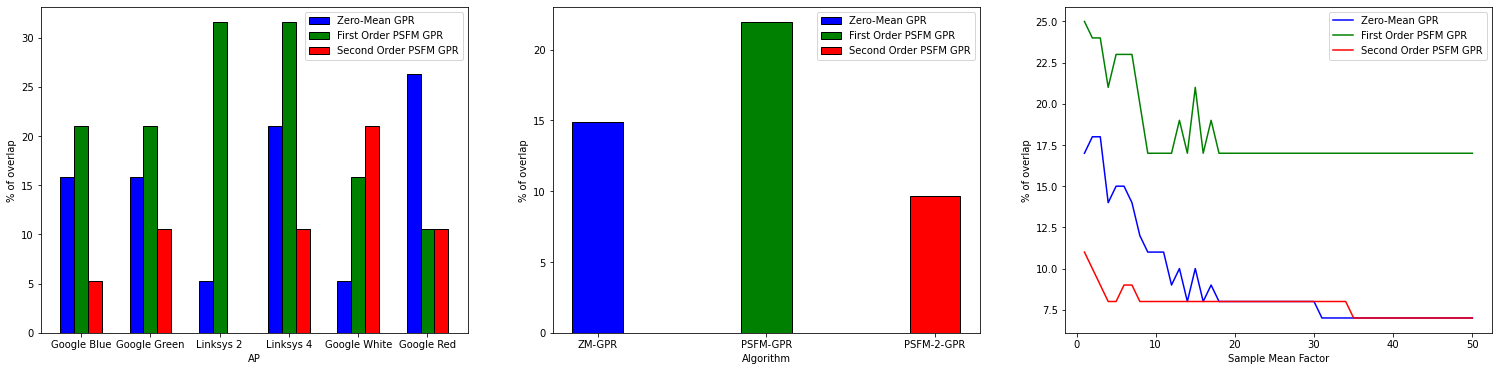

In [69]:
factor = factor_slider.value

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (26, 6))
bar_width = 0.2

ax1.bar(np.arange(n_ap) - bar_width, (np.sum(zero_mean_interval_overlap[factor - 1], axis=1)/n_vrp)*100, color = 'b',
        width = bar_width, edgecolor = 'black',
        label='Zero-Mean GPR')
ax1.bar(np.arange(n_ap), (np.sum(psfm_interval_overlap[factor - 1], axis=1)/n_vrp)*100, color = 'g',
        width = bar_width, edgecolor = 'black',
        label='First Order PSFM GPR')
ax1.bar(np.arange(n_ap) + bar_width, (np.sum(psfm2_interval_overlap[factor - 1], axis=1)/n_vrp)*100, color = 'r',
        width = bar_width, edgecolor = 'black',
        label='Second Order PSFM GPR')
  
ax1.set_xlabel("AP")
ax1.set_ylabel("% of overlap")

ax1.set_xticks(np.arange(n_ap))
ax1.set_xticklabels(ap_labels.values())
ax1.legend()

bar_width = 0.3

ax2.bar(0, (np.sum(zero_mean_interval_overlap[factor - 1])/(n_vrp * n_ap))*100, color = 'b',
        width = bar_width, edgecolor = 'black',
        label='Zero-Mean GPR')
ax2.bar(1, (np.sum(psfm_interval_overlap[factor - 1])/(n_vrp * n_ap))*100, color = 'g',
        width = bar_width, edgecolor = 'black',
        label='First Order PSFM GPR')
ax2.bar(2, (np.sum(psfm2_interval_overlap[factor - 1])/(n_vrp * n_ap))*100, color = 'r',
        width = bar_width, edgecolor = 'black',
        label='Second Order PSFM GPR')

ax2.set_xlabel("Algorithm")
ax2.set_ylabel("% of overlap")

ax2.set_xticks(np.arange(3))
ax2.set_xticklabels(['ZM-GPR', 'PSFM-GPR', 'PSFM-2-GPR'])
ax2.legend()

ax3.plot(np.arange(n_samples) + 1, np.sum(np.sum(zero_mean_interval_overlap,axis=1),axis=1), label="Zero-Mean GPR", color="b")
ax3.plot(np.arange(n_samples) + 1, np.sum(np.sum(psfm_interval_overlap,axis=1),axis=1), label="First Order PSFM GPR", color="g")
ax3.plot(np.arange(n_samples) + 1, np.sum(np.sum(psfm2_interval_overlap,axis=1),axis=1), label="Second Order PSFM GPR", color="r")

ax3.set_xlabel("Sample Mean Factor")
ax3.set_ylabel("% of overlap")
ax3.legend()

plt.show()